# Audio Classification

This notebook serves as an exmaple of how to conduct an end to end audio classification model.

In [66]:
# Import Necessary Modules

import os
import hub
import wave
import wandb
import pathlib

import matplotlib.pyplot as plt 
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np

from wandb.keras import WandbCallback
from tensorflow.keras import models, Sequential, layers
from IPython.display import display, Audio
from ipywidgets import interactive

seed = 0

tf.random.set_seed(seed)
np.random.seed(seed)

# Preview version of Tensorflow
print("This notebook is using {} version of Tensorflow".format(tf.__version__))


ImportError: cannot import name 'Dense' from 'tensorflow.keras' (/Users/moyoajayi/miniforge3/envs/env-tf/lib/python3.8/site-packages/tensorflow/python/keras/api/_v2/keras/__init__.py)

## Acquire Data

For this classification project the data that will be used is sourced from the [Free Spoken Digit Data set (FSSD)](https://github.com/Jakobovski/free-spoken-digit-dataset). This data set provides the user with 3,000 recordings from six different speakers.

In [53]:
# Obtain the data using the hub module

ds = hub.load("hub://activeloop/spoken_mnist")

Opening dataset in read-only mode as you don't have write permissions.
hub://activeloop/spoken_mnist loaded successfully.


/Users/moyoajayi/miniforge3/envs/env-tf/lib/python3.8/site-packages/hub/core/fast_forwarding.py:44: UserWarning: Loading a dataset that was created with a newer version of hub. This could lead to corruption or weird errors! Dataset version: 2.2.4, current hub version: 2.2.3. It's recommended that you update to a version of hub >= 2.2.4.
  warnings.warn(


This dataset can be visualized at https://app.activeloop.ai/activeloop/spoken_mnist.


Based on the description of the data by the source [repository](https://github.com/Jakobovski/free-spoken-digit-dataset#usage), the first five recordings by each speaker (0-4) are to be considered the test set and the remaining recordings per speaker (5-49) should be considered the training set.

## EDA

Explore the data set retrieved from the previous step. To begin, let's examine the tensors belonging to the downloaded dataset, specifically, the name of each tensor. 

In [54]:
ds.tensors.keys()

dict_keys(['spectrograms', 'labels', 'audio', 'speakers'])

The execution of the preivous cell highlights four categories:
1. `spectrograms`: visual repreentations of the frequency, amplitude, and length of time for the recorded sound.
2. `labels`: These are labels that tell the user which number was spoken (e.g. "0", "3"). These numbers are recorded within arrays
3. `audio`: The audio for each of the spoken numbers is reorded in this tensor
4. `speakers`: A string that indicates the first name of the speaker

In [81]:
ds.speakers[300].numpy()

array(['george'], dtype='<U6')

In [82]:
ds.labels[300].numpy()

array([1], dtype=uint32)

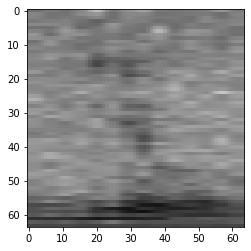

In [61]:

plt.imshow(ds.spectrograms[150])
plt.show()

## Play Audio from Data Set

To get a feel of the audio that was actually recorded by the speakers, we can extract the sound from the `audio` tenor within the data set (`ds`). 

_As of 20 Feb, the widget is **not** working for an unknown reason_

In [ ]:
# Toy Function to play beats in notebook
def beat_freq(f1=220.0, f2=224.0):
    max_time = 5
    rate = 8000
    times = np.linspace(0,max_time,rate*max_time)
    signal = np.sin(2*np.pi*f1*times) + np.sin(2*np.pi*f2*times)
    display(Audio(data=signal, rate=rate))
    return signal

v = interactive(beat_freq, f1=(200.0,300.0), f2=(200.0,300.0))
display(v)

interactive(children=(FloatSlider(value=220.0, description='f1', max=300.0, min=200.0), FloatSlider(value=224.…

In [28]:
samp = "/Users/moyoajayi/Documents/audio-classification-education/data/WATRWave_Sea waves (ID 0266)_BSB.wav"
sample = ds.audio[0].numpy()
display(Audio(data=sample, rate = 8000, autoplay=True))

In [42]:
ds_tf = ds.tensorflow()
type(ds_tf)

tensorflow.python.data.ops.dataset_ops.FlatMapDataset

In [27]:
count = 0
for tensor in ds.tensorflow(): 
    print(tensor.audio.data())
    if count == 3:
        continue
    count = count + 1

/Users/moyoajayi/miniforge3/envs/env-tf/lib/python3.8/site-packages/hub/core/fast_forwarding.py:44: UserWarning: Loading a dataset that was created with a newer version of hub. This could lead to corruption or weird errors! Dataset version: 2.2.4, current hub version: 2.2.3. It's recommended that you update to a version of hub >= 2.2.4.
  warnings.warn(
2022-02-20 12:27:19.350138: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-20 12:27:19.350301: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


AttributeError: 'dict' object has no attribute 'audio'

## Build Tensorflow Model

In [65]:
# Convert the dataset to a tenforflow dataset object

df_tf = ds.tensorflow()
type(df_tf)
# print("The data set downloaded from hub has be converted to a tensorflow dataset")

tensorflow.python.data.ops.dataset_ops.FlatMapDataset

In [68]:
simple_seq_mdl = Sequential()

simple_seq_mdl.add(
    layers.Dense(10, input_shape=(3000,), 
    activation="relu")
)
# Add an output layer of 10 to represent the ten possible classes that could come from the model
simple_seq_mdl.add(layers.Dense(10))

simple_seq_mdl.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                30010     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
Total params: 30,120
Trainable params: 30,120
Non-trainable params: 0
_________________________________________________________________
